# R-CNN Implementation on Martian/Lunar Crater Dataset

In [2]:
!pip install opencv-contrib-python

In [3]:
!pip install keras

In [4]:
!pip install tensorflow

In [2]:
# Importing Libraries
import os,cv2
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [6]:
# Initialising selective search
cv2.setUseOptimized(True);      # optimizing code paths to improve performace
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [7]:
print(cv2.__version__)

4.10.0


In [8]:
# Storing the paths as strings
path = "C:\\Users\\Advaithaa\\OneDrive\\Desktop\\Spartificial-Internship\\Craters-Dataset\\craters\\train\\images"
annot = "C:\\Users\\Advaithaa\\OneDrive\\Desktop\\Spartificial-Internship\\Craters-Dataset\\craters\\train\\labels"

In [29]:
os.listdir(path)

['011_png.rf.8ac312b4898f0106d10b76952a55d237.jpg',
 '012_png.rf.64da6ff4c62638096ee6e5bf689706bc.jpg',
 '013_png.rf.ee44d5aa33fd33a1ed62ae233180f505.jpg',
 '016_png.rf.1973f9540ae7f672257609a8e5721ab3.jpg',
 '017_png.rf.1504c0d3ecbf20af6bc5114ca197a0dd.jpg',
 '018_png.rf.2d4eed5581681fe83830e51634befdaf.jpg',
 '01_png.rf.4d2ebc5ed98ad1e69d667aadbce63d53.jpg',
 '020_png.rf.ce87f4889d7441275135633392f98ed7.jpg',
 '022_png.rf.00ae4e655a2774bada1e254641482935.jpg',
 '02_png.rf.610687947e4c92f77e6462104ec4b924.jpg',
 '03_png.rf.8f7b31e14642026833b7c0dcd1832862.jpg',
 '05_png.rf.844343145246e51e66a345419e1862bf.jpg',
 '06_png.rf.aaf8c66b9e4d5e99a3dc70bae7f62c07.jpg',
 '07_png.rf.3fba5e95c6827aa6c4132e70f2086555.jpg',
 '08_png.rf.944efdd0f108140b368d7ad2c37426df.jpg',
 '09_png.rf.3b796e77a5f0036af4cd4413fcbe07a5.jpg',
 'mars_crater--0-_jpg.rf.40c1dec94c66ab07d9da8c74fa58d6f8.jpg',
 'mars_crater--10-_jpg.rf.585b1aa305997e3055e86fcac72a806b.jpg',
 'mars_crater--101-_jpg.rf.8f4eb1c77ab9e64d2fd6

In [11]:
os.listdir(annot)[2]

'013_png.rf.ee44d5aa33fd33a1ed62ae233180f505.txt'

013_png.rf.ee44d5aa33fd33a1ed62ae233180f505.jpg
(640, 640, 3)


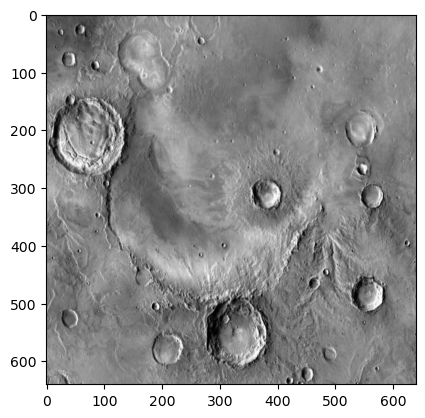

In [11]:
# viewing an image
#from google.colab.patches import cv2_imshow

file_name = os.listdir(path)[2]
print(file_name)
img = cv2.imread(os.path.join(path,file_name))
print(img.shape)
plt.imshow(img)

011_png.rf.8ac312b4898f0106d10b76952a55d237.jpg


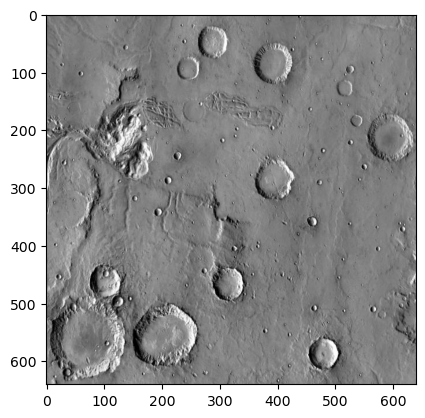

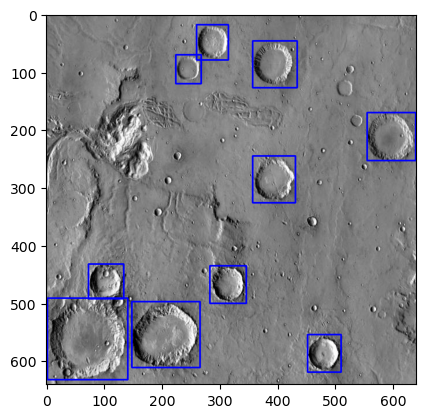

In [32]:
for e, i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".txt")[0] + ".jpg"
        print(filename)

        # Read the image
        img = cv2.imread(os.path.join(path, filename))
        if img is None:
            print(f"Image not found: {filename}")
            continue
        img = img.astype("float32") / 255.0

        # Read the annotation file
        with open(os.path.join(annot, i), "r") as file:
            lines = file.readlines()

        # Plot the image and bounding boxes
        plt.imshow(img)
        for line in lines:
            # Split the line into components
            components = line.strip().split()

            # Check if the line has at least 4 values (x1, y1, x2, y2)
            if len(components) < 4:
                print(f"Invalid line in {i}: {line}")
                continue

            # Extract and process coordinates
            try:
                center_x, center_y, bbox_width, bbox_height = map(float, components[1:])  # Take the last four values
                x1 = int((center_x - bbox_width / 2) * width)
                x2 = int((center_x + bbox_width / 2) * width)
                y1 = int((center_y - bbox_height / 2) * height)
                y2 = int((center_y + bbox_height / 2) * height)

                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                if img.dtype == np.float32 or img.dtype == np.float64:
                    img = np.clip(img, 0, 1)  # Clip to [0, 1] for floats
                else:
                    img = np.clip(img, 0, 255).astype(np.uint8)  # Clip to [0, 255] for integers
            except ValueError as ve:
                print(f"Error parsing line in {i}: {line}")
                print(ve)
                continue

        # Show the annotated image
        plt.figure()
        plt.imshow(img)
        break

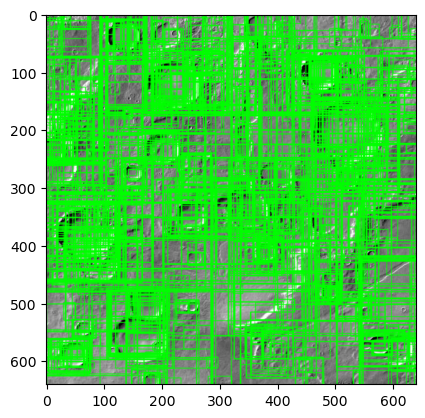

In [34]:
## Creating boxes using Selective Search on one image
im = cv2.imread(os.path.join(path,"018_png.rf.2d4eed5581681fe83830e51634befdaf.jpg"))
ss.setBaseImage(im)       # setting this image as the base image for selective search algo
ss.switchToSelectiveSearchFast()      # switching to fast selective search for optimization
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

Calculating IoU between predicted bounding boxes

In [10]:
def get_iou(bb1, bb2):
    # Assertions are used to confirm that the 2 bounding boxes are properly defined
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # Calculating the intersecting coordinates
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # If this condition is true, the bounding boxes do not overlap, hence IoU 0.0 is returned
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Area of the intersection rectangle is calculated
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Area of both the bounding boxes is calculated
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # IoU score is calculated using the formula intersection area/union
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    # Checking if the IoU is between 0.0 and 1.0
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
# Creating empty arrays for train images and labels

train_images=[]
train_labels=[]

In [14]:
train_bboxes = [] 

Running Selective Search and calculating IoU scores for all images

In [16]:
for e, i in enumerate(os.listdir(annot)):
    try:
        filename = i.split(".txt")[0] + ".jpg"
        image_path = os.path.join(path, filename)
        annotation_path = os.path.join(annot, i)
        print(image_path)
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            continue
        
        height, width, _ = image.shape

        # Read YOLO annotations
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            # Split the line into components
            components = line.strip().split()
        center_x, center_y, bbox_width, bbox_height = map(float, components[1:])  # Take the last four values

        gtvalues = [
            {"x1": int((center_x - bbox_width / 2) * width),
             "y1": int((center_y - bbox_height / 2) * height),
             "x2": int((center_x + bbox_width / 2) * width),
             "y2": int((center_y + bbox_height / 2) * height)}
                   ]

        # Initialize selective search
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()[:1000]  

        imout = image.copy()
        added_bboxes = set()  # Use a set for faster duplicate checking

        for result in ssresults:
            x, y, w, h = result
            if w < 20 or h < 20:  # Skip very small regions
                continue

            proposed_bbox = (x, y, x + w, y + h)
            if proposed_bbox in added_bboxes:
                continue  # Skip duplicates early

            # Calculate IoU with ground truth boxes
            max_iou = 0
            best_gtval = None
            for gtval in gtvalues:
                iou = get_iou(gtval, {"x1": x, "y1": y, "x2": x + w, "y2": y + h})
                if iou > max_iou:
                    max_iou = iou
                    best_gtval = gtval

            # Label regions based on IoU
            if max_iou > 0.70:  # True positive
                label = 1
            elif max_iou < 0.3:  # False positive
                label = 0
            else:
                continue  # Ignore regions with uncertain IoU

            # Crop, resize, and store the region
            timage = imout[y:y + h, x:x + w]
            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
            train_images.append(resized)
            train_labels.append(label)
            train_bboxes.append([x, y, x + w, y + h])
            added_bboxes.add(proposed_bbox)  # Track processed bounding boxes

    except Exception as e:
        print(f"Error processing file {i}: {e}")


C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\train\images\011_png.rf.8ac312b4898f0106d10b76952a55d237.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\train\images\012_png.rf.64da6ff4c62638096ee6e5bf689706bc.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\train\images\013_png.rf.ee44d5aa33fd33a1ed62ae233180f505.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\train\images\016_png.rf.1973f9540ae7f672257609a8e5721ab3.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\train\images\017_png.rf.1504c0d3ecbf20af6bc5114ca197a0dd.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\train\images\018_png.rf.2d4eed5581681fe83830e51634befdaf.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\train\images\01_png.rf.4d2ebc5ed98ad1e69d667aa

In [18]:
print("Number of train n images:", len(train_images))
print("Number of classification labels:", len(train_labels))
print("Number of bounding box labels:", len(train_bboxes))

Number of train n images: 52267
Number of classification labels: 52267
Number of bounding box labels: 52267


In [20]:
X_train = np.array(train_images)
y_train = np.array(train_labels)

In [22]:
train_bboxes = np.array(train_bboxes)

In [23]:
X_train.shape, X_train.size, train_bboxes.shape

((52267, 224, 224, 3), 7867646976, (52267, 4))

In [24]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

In [26]:
y_train.shape

(52267, 2)

In [161]:
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

X_train dtype: uint8
y_train dtype: float64


In [31]:
y_train.dtype

dtype('float64')

In [28]:
train_bboxes[:5]

array([[ 70, 507, 136, 623],
       [233, 288, 296, 349],
       [ 27, 502, 118, 621],
       [  0,   0, 640, 640],
       [244,  62, 269, 115]])

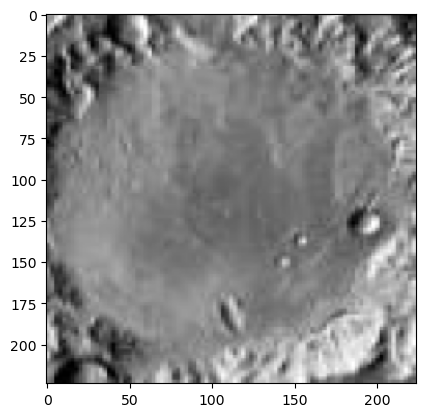

In [31]:
plt.imshow(X_train[2])

#### Performing operations on val set 

In [30]:
path_val = "C:\\Users\\Advaithaa\\OneDrive\\Desktop\\Spartificial-Internship\\Craters-Dataset\\craters\\valid\\images"
annot_val = "C:\\Users\\Advaithaa\\OneDrive\\Desktop\\Spartificial-Internship\\Craters-Dataset\\craters\\valid\\labels"

In [32]:
val_images = []
val_labels = []

In [34]:
val_bboxes = []

In [36]:
for e, i in enumerate(os.listdir(annot_val)):
    try:
        filename1 = i.split(".txt")[0] + ".jpg"
        image_path_val = os.path.join(path_val, filename1)
        annotation_path_val = os.path.join(annot_val, i)
        print(image_path_val)
        # Read the image
        image_val = cv2.imread(image_path_val)
        if image_val is None:
            print(f"Image not found: {image_path_val}")
            continue
        
        height1, width1, _ = image_val.shape

        # Read YOLO annotations
        with open(annotation_path_val, 'r') as f:
            lines1 = f.readlines()
        for line1 in lines1:
            components1 = line1.strip().split()
        center_x1, center_y1, bbox_width1, bbox_height1 = map(float, components1[1:])
        
        gtvalues1 = [
            {"x1": int((center_x1 - bbox_width1 / 2) * width1),
             "y1": int((center_y1 - bbox_height1 / 2) * height1),
             "x2": int((center_x1 + bbox_width1 / 2) * width1),
             "y2": int((center_y1 + bbox_height1 / 2) * height1)}
                    ]

        # Initialize selective search
        ss.setBaseImage(image_val)
        ss.switchToSelectiveSearchFast()
        ssresults1 = ss.process()[:1000]  

        imout1 = image_val.copy()
        added_bboxes_val = set()  # Use a set for faster duplicate checking

        for result1 in ssresults1:
            x_val, y_val, w_val, h_val = result1
            if w_val < 20 or h_val < 20:  # Skip very small regions
                continue

            proposed_bbox_val = (x_val, y_val, x_val + w_val, y_val + h_val)
            if proposed_bbox_val in added_bboxes_val:
                continue  # Skip duplicates early

            # Calculate IoU with ground truth boxes
            max_iou1 = 0
            best_gtval1 = None
            for gtval1 in gtvalues1:
                iou1 = get_iou(gtval1, {"x1": x_val, "y1": y_val, "x2": x_val + w_val, "y2": y_val + h_val})
                if iou1 > max_iou1:
                    max_iou1 = iou1
                    best_gtval1 = gtval1

            # Label regions based on IoU
            if max_iou1 > 0.70:  # True positive
                label1 = 1
            elif max_iou1 < 0.3:  # False positive
                label1 = 0
            else:
                continue  # Ignore regions with uncertain IoU

            # Crop, resize, and store the region
            timage1 = imout1[y_val:y_val + h_val, x_val:x_val + w_val]
            resized1 = cv2.resize(timage1, (224, 224), interpolation=cv2.INTER_AREA)
            val_images.append(resized1)
            val_labels.append(label1)
            val_bboxes.append([x_val, y_val, x_val + w_val, y_val + h_val])
            added_bboxes_val.add(proposed_bbox_val)  # Track processed bounding boxes

    except Exception as e:
        print(f"Error processing file {i}: {e}")


C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\valid\images\014_png.rf.6b86c8afeb3ebca92872fd966d076adc.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\valid\images\021_png.rf.575e0f1cb87a2cc439172de15816c2cc.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\valid\images\023_png.rf.0a3106bdcc8e64bba283f961db77c9ec.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\valid\images\024_png.rf.be24000681f4f356e2a027fb7ca0c552.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\valid\images\mars_crater--1-_png.rf.f1b399f95708fd0ce520f23c9944ed44.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\valid\images\mars_crater--104-_jpg.rf.2ff6036b976ac6bbba612dd48f144d4d.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\valid\images\mars_cr

In [55]:
print(f"Type of val_images: {type(val_images)}")

Type of val_images: <class 'list'>


In [38]:
X_val = np.array(val_images)
y_val = np.array(val_labels)

In [40]:
val_bboxes = np.array(val_bboxes)

In [42]:
print("Number of validation images:", len(val_images))
print("Number of classification labels:", len(val_labels))
print("Number of bounding box labels:", len(val_bboxes))

Number of validation images: 14608
Number of classification labels: 14608
Number of bounding box labels: 14608


In [47]:
X_val.shape, X_val.size,val_bboxes.shape

((14608, 224, 224, 3), 2198913024, (14608, 4))

In [44]:
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [46]:
y_val.shape

(14608, 2)

In [85]:
y_val.dtype

dtype('float64')

In [48]:
val_bboxes[1]

array([ 20, 386,  42, 432])

In [71]:
y_val[0]

array([1., 0.])

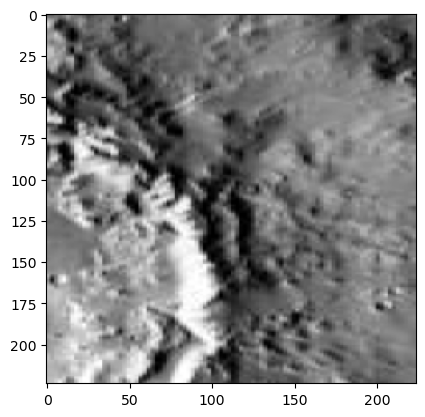

In [73]:
plt.imshow(X_val[5])

In [55]:
pip install --upgrade tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [23]:
# Transfer learning on the imagenet weight.
# Importing VGG16 model and puting the imagenet weight in the model.

In [50]:
from keras.layers import Dense,Flatten
from keras import Model
from keras import optimizers
from keras.applications import ResNet50
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

In [52]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [54]:
minput = resnet_model.input
minput

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>

In [56]:
input_shape = resnet_model.input.shape  # This gives (batch_size, height, width, channels)

# Extract height and width
image_height = int(input_shape[1])
image_width = int(input_shape[2])
print(image_height)
print(image_width)

224
224


In [58]:
train_bboxes = train_bboxes / [width, height, width, height]
val_bboxes = val_bboxes / [width1, height1, width1, height1]

In [60]:
print(train_bboxes[:2])
print(val_bboxes[:2])

[[0.109375  0.7921875 0.2125    0.9734375]
 [0.3640625 0.45      0.4625    0.5453125]]
[[0.2921875 0.609375  0.325     0.6515625]
 [0.03125   0.603125  0.065625  0.675    ]]


In [62]:
print(height1)
print(width1)

640
640


Transfer learning:
1. The initial layers of the model are frozen.
2. Adam optimizer is used with a small learning rate to retain the features learned by the pre-trained model.
3. Categorial cross-entropy is used as the loss for classification, and IoU loss for bounding box regression

In [64]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU

In [66]:
from tensorflow.keras.losses import CategoricalCrossentropy

categorical_loss = CategoricalCrossentropy(from_logits=False)

In [68]:
def smooth_l1_loss(y_true, y_pred, beta=1.0):
    """
    Compute the Smooth L1 loss, also known as Huber loss.
    Smooth L1 loss transitions between L1 and L2 losses depending on the error magnitude.
    :param y_true: Ground truth bounding boxes, shape (batch_size, 4), [x1, y1, x2, y2]
    :param y_pred: Predicted bounding boxes, shape (batch_size, 4), [x1, y1, x2, y2]
    :param beta: Transition point between L1 and L2 loss, typically set to 1.0
    :return: Smooth L1 loss value
    """
    y_pred_scaled = y_pred * tf.convert_to_tensor([image_width, image_height, image_width, image_height], dtype=tf.float32)    
    diff = tf.abs(y_true - y_pred)
    loss = tf.where(
        tf.less(diff, beta),
        0.5 * tf.square(diff) / beta,
        diff - 0.5 * beta
    )
    return tf.reduce_mean(loss)


In [314]:
# def iou_metric(y_true, y_pred):
#     x1_true, y1_true = y_true[:, 0], y_true[:, 1]
#     x2_true, y2_true = y_true[:, 2], y_true[:, 3]

#     x1_pred, y1_pred = y_pred[:, 0], y_pred[:, 1]
#     x2_pred, y2_pred = y_pred[:, 2], y_pred[:, 3]


#     xi1 = tf.maximum(x1_true, x1_pred)
#     yi1 = tf.maximum(y1_true, y1_pred)
#     xi2 = tf.minimum(x2_true, x2_pred)
#     yi2 = tf.minimum(y2_true, y2_pred)
#     inter_area = tf.maximum(0.0, xi2 - xi1) * tf.maximum(0.0, yi2 - yi1)

#     true_area = (x2_true - x1_true) * (y2_true - y1_true)
#     pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
#     union_area = true_area + pred_area - inter_area

#     iou = inter_area / tf.maximum(union_area, 1e-6)
#     return iou


In [70]:
for layer in (resnet_model.layers)[:]:
    print(layer)
    layer.trainable = False
x = Flatten()(resnet_model.output)
# Adding dense and dropout layers
x = Dense(256)(x)  # Additional dense layer
x = LeakyReLU(alpha=0.1)(x)  
x = Dropout(0.5)(x)  # Dropout for regularization
classification_output = Dense(2, activation="softmax", name="classification")(x)  # Classification head

# Adding layers before bounding box regression 
# x = Dense(1024)(x)
# x = LeakyReLU(alpha=0.1)(x)
# x = Dense(512)(x)
# x = LeakyReLU(alpha=0.1)(x) 
x = Dense(256)(x)  
x = LeakyReLU(alpha=0.1)(x)  
x = Dense(128)(x) 
x = LeakyReLU(alpha=0.1)(x)  
x = Dropout(0.5)(x) 

bbox_output = Dense(4, activation="linear", name="bbox_regression")(x)
print(f"Shape : {bbox_output.shape}") 
# bbox_output = Lambda(lambda b: b * tf.convert_to_tensor([image_width, image_height, image_width, image_height], dtype=tf.float32), name="bbox_regression")(bbox_output)
# print("Bounding box regression output shape:", bbox_output.shape)
model_1 = Model(inputs=minput, outputs={"classification": classification_output, "bbox_regression": bbox_output})

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.9
)

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        "classification": categorical_loss,
        "bbox_regression": smooth_l1_loss,  
    },
    loss_weights={
        "classification": 1.0,
        "bbox_regression": 0.3,  
    },
    metrics={
        "classification": ["accuracy"],
        "bbox_regression": ["mse"],
    },
)

model_1.summary()

<InputLayer name=input_layer, built=True>
<ZeroPadding2D name=conv1_pad, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=pool1_pad, built=True>
<MaxPooling2D name=pool1_pool, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<BatchNormalization name=conv2_block1_2_bn, built=True>
<Activation name=conv2_block1_2_relu, built=True>
<Conv2D name=conv2_block1_0_conv, built=True>
<Conv2D name=conv2_block1_3_conv, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<BatchNormalization name=conv2_block1_3_bn, built=True>
<Add name=conv2_block1_add, built=True>
<Activation name=conv2_block1_out, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Activa

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,377,798 (188.36 MB)

 Trainable params: 25,790,086 (98.38 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [74]:
print(model_1.outputs)

[<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_185>, <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_179>]


In [76]:
print(bbox_output.shape) 

(None, 4)


In [78]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(52267, 224, 224, 3) (14608, 224, 224, 3) (52267, 2) (14608, 2)


In [97]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping

In [80]:
print("Bounding box labels shape:", train_bboxes.shape)  # Should be (N, 4)
print("First bounding box:", train_bboxes[0])

Bounding box labels shape: (52267, 4)
First bounding box: [0.109375  0.7921875 0.2125    0.9734375]


In [82]:
batch_size = 32

In [84]:
# Create the dataset
X_train_small = X_train[:30000]
y_train_small = y_train[:30000]
train_bboxes_small = train_bboxes[:30000]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_small,   {"classification": y_train_small, "bbox_regression": train_bboxes_small}
                                                   )).batch(batch_size)
X_val_small = X_val[:10000]
y_val_small = y_val[:10000]
val_bboxes_small = val_bboxes[:10000]

test_dataset = tf.data.Dataset.from_tensor_slices((X_val_small,{"classification": y_val_small, "bbox_regression": val_bboxes_small}
                                                  )).batch(batch_size)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [86]:
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), 
                                                {"classification": tf.cast(y["classification"], tf.float32),
                                                 "bbox_regression": tf.cast(y["bbox_regression"], tf.float32)}))

In [88]:
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), 
                                                {"classification": tf.cast(y["classification"], tf.float32),
                                                 "bbox_regression": tf.cast(y["bbox_regression"], tf.float32)}))

In [90]:
train_bboxes_small.shape, val_bboxes_small.shape

((30000, 4), (10000, 4))

In [92]:
train_bboxes_small.dtype

dtype('float64')

In [96]:
print(model_1.output_names)

ListWrapper(['bbox_regression', 'classification'])


In [98]:
for images, labels in train_dataset.take(1):
    print("Input images shape:", images.shape)  
    print("Classification labels shape:", labels['classification'].shape)  
    print("Bounding box labels shape:", labels['bbox_regression'].shape) 
    print("Classification labels sample:", labels['classification'][0])  
    print("Bounding box labels sample:", labels['bbox_regression'][0])

Input images shape: (32, 224, 224, 3)
Classification labels shape: (32, 2)
Bounding box labels shape: (32, 4)
Classification labels sample: tf.Tensor([1. 0.], shape=(2,), dtype=float32)
Bounding box labels sample: tf.Tensor([0.109375  0.7921875 0.2125    0.9734375], shape=(4,), dtype=float32)


In [100]:
steps_per_epoch = len(train_dataset) // batch_size
validation_steps = len(test_dataset) // batch_size

model_1.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose = 1
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - bbox_regression_loss: 0.9463 - bbox_regression_mse: 22.5917 - classification_accuracy: 0.9376 - classification_loss: 0.1489 - loss: 1.0952 - val_bbox_regression_loss: 0.0459 - val_bbox_regression_mse: 0.3108 - val_classification_accuracy: 1.0000 - val_classification_loss: 0.0000e+00 - val_loss: 0.0459
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - bbox_regression_loss: 0.3188 - bbox_regression_mse: 3.7388 - classification_accuracy: 1.0000 - classification_loss: 2.9632e-06 - loss: 0.3188 - val_bbox_regression_loss: 0.0240 - val_bbox_regression_mse: 0.1608 - val_classification_accuracy: 1.0000 - val_classification_loss: 4.0728e-06 - val_loss: 0.0240
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - bbox_regression_loss: 0.1113 - bbox_regression_mse: 0.8830 - classification_accuracy: 0.9998 - classification_loss: 0.0040 - loss: 0.1153 - val_bbox_regression_loss: 0.0274 - val_bbox_regression_mse: 0.1826 - val_classification_accura

In [104]:
# Get predictions for mAP calculation
y_pred = model_1.predict(test_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step


In [106]:
print("Type of predictions:", type(y_pred))  # Should be a tuple or list
print("Length of predictions:", len(y_pred))  # Should be 2 for two outputs (classification and bbox)

Type of predictions: <class 'dict'>
Length of predictions: 2


In [108]:
# Print the type and the keys of the predictions dictionary
print("Type of predictions:", type(y_pred))  # Should be a dictionary
print("Keys of predictions:", y_pred.keys())  # Should contain 'classification' and 'bbox_regression'

# Access the predicted classification and bounding box values
y_pred_class = y_pred['classification']
y_pred_bbox = y_pred['bbox_regression']

# Check the predicted class and bbox values
print("Predicted classification probabilities:", y_pred_class)
print("Predicted bounding boxes:", y_pred_bbox)


Type of predictions: <class 'dict'>
Keys of predictions: dict_keys(['classification', 'bbox_regression'])
Predicted classification probabilities: [[9.9944061e-01 5.5942772e-04]
 [9.9993253e-01 6.7501162e-05]
 [9.9990833e-01 9.1641916e-05]
 ...
 [9.9758279e-01 2.4172107e-03]
 [9.9694139e-01 3.0586370e-03]
 [9.9886912e-01 1.1308320e-03]]
Predicted bounding boxes: [[0.21625997 0.3869143  0.3394199  0.38239276]
 [0.19539545 0.3276195  0.22758006 0.24794793]
 [0.19946058 0.3370411  0.32090712 0.36340797]
 ...
 [0.15325817 0.1752151  0.25905314 0.26985735]
 [0.22765966 0.21396506 0.33200628 0.38415933]
 [0.13686368 0.23512591 0.14127485 0.14975245]]


In [124]:
type(y_pred_bbox)

numpy.ndarray

In [353]:
box = np.array(y_pred_bbox[0])
box = np.expand_dims(box, axis = 0)
box.shape

(1, 4)

In [355]:
np.argmax(y_pred_class[74][1])

0

In [114]:
for i, scores in enumerate(y_pred_class):
    print(f"Prediction {i} scores:", scores)  # Print raw scores for each class

Prediction 0 scores: [9.994406e-01 5.594277e-04]
Prediction 1 scores: [9.999325e-01 6.750116e-05]
Prediction 2 scores: [9.9990833e-01 9.1641916e-05]
Prediction 3 scores: [9.9976426e-01 2.3574643e-04]
Prediction 4 scores: [9.9997640e-01 2.3600016e-05]
Prediction 5 scores: [9.993205e-01 6.795339e-04]
Prediction 6 scores: [9.999337e-01 6.625199e-05]
Prediction 7 scores: [9.9973685e-01 2.6320069e-04]
Prediction 8 scores: [9.9999678e-01 3.2723617e-06]
Prediction 9 scores: [9.991891e-01 8.109226e-04]
Prediction 10 scores: [9.9998558e-01 1.4444718e-05]
Prediction 11 scores: [9.9995291e-01 4.7083944e-05]
Prediction 12 scores: [9.9999511e-01 4.8883167e-06]
Prediction 13 scores: [9.9970537e-01 2.9459206e-04]
Prediction 14 scores: [9.9999762e-01 2.4061737e-06]
Prediction 15 scores: [9.9993122e-01 6.8778674e-05]
Prediction 16 scores: [9.9953699e-01 4.6301566e-04]
Prediction 17 scores: [9.999372e-01 6.285886e-05]
Prediction 18 scores: [9.9957985e-01 4.2012156e-04]
Prediction 19 scores: [9.9999976e-

In [ ]:
# Computing mAP

In [132]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

def compute_map(y_true, y_pred, iou_threshold=0.5):
    """
    Compute mean Average Precision (mAP).
    
    Args:
        y_true: List of dictionaries with 'boxes' (ground truth boxes) and 'class_id'.
        y_pred: List of dictionaries with 'boxes' (predicted boxes), 'scores', and 'class_id'.
        iou_threshold: IoU threshold for a match.
    
    Returns:
        Mean Average Precision (mAP).
    """
    def calculate_iou(box1, box2):
        """Calculate IoU between two bounding boxes."""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0

    aps = []

    # Group by classes
    classes = set(t['class_id'] for t in y_true) | set(p['class_id'] for p in y_pred)
    
    for cls in classes:
        # Filter ground truths and predictions by class
        gt_boxes = [t['boxes'] for t in y_true if t['class_id'] == cls]
        pred_boxes = [p['boxes'] for p in y_pred if p['class_id'] == cls]
        pred_scores = [p['scores'] for p in y_pred if p['class_id'] == cls]

        if not gt_boxes or not pred_boxes:
            aps.append(0.0)
            continue

        # Sort predictions by confidence
        sorted_indices = np.argsort(pred_scores)[::-1]
        pred_boxes = np.array(pred_boxes)[sorted_indices]
        pred_scores = np.array(pred_scores)[sorted_indices]

        # Match predictions to ground truths
        matched_gt = set()
        y_true_binary = []
        y_scores = []

        for pred_box, pred_score in zip(pred_boxes, pred_scores):
            # Find best IoU match
            ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
            max_iou = max(ious, default=0)
            max_idx = ious.index(max_iou) if max_iou >= iou_threshold else -1

            if max_idx >= 0 and max_idx not in matched_gt:
                y_true_binary.append(1)  # True positive
                matched_gt.add(max_idx)
            else:
                y_true_binary.append(0)  # False positive

            y_scores.append(pred_score)

        # Add false negatives for unmatched ground truths
        unmatched_gt = len(gt_boxes) - len(matched_gt)
        y_true_binary.extend([1] * unmatched_gt)
        y_scores.extend([0] * unmatched_gt)

        # Calculate average precision for the class
        aps.append(average_precision_score(y_true_binary, y_scores))

    # Return mean Average Precision
    return np.mean(aps)


In [ ]:
# Evaluating mAP

In [134]:
# Prepare ground truth
y_true_map = [{'boxes': b, 'class_id': int(np.argmax(c))} for b, c in zip(val_bboxes_small, y_val)]

# Prepare predictions
y_pred_map = [
    {'boxes': b, 'scores': float(max(s)), 'class_id': int(np.argmax(s))}
    for b, s in zip(y_pred_bbox, y_pred_class)
]

# Compute mAP score
map_score = compute_map(y_true_map, y_pred_map, iou_threshold=0.7)
print(f"mAP Score (IoU threshold 0.7): {map_score}")

mAP Score (IoU threshold 0.7): 0.5806025242270126


In [144]:
prediction_boxes_with_scores = [
    {"bbox": bbox, "confidence": confidence}
    for bbox, confidence in zip(y_pred_bbox, y_pred_class)
]

In [206]:
for pred in prediction_boxes_with_scores:
    print(max(pred['confidence']))
    break

0.9994406


##### Applying Non-Max Suppression

In [ ]:
# Applying NMS and re-calculating mAP

In [136]:
import torch

In [238]:
def nms_pytorch(P: torch.tensor, thresh_iou: float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.

    Args:
        P: (tensor) The location predictions for the image 
            along with the class prediction scores, Shape: [num_boxes, 5].
            The tensor P contains bounding box coordinates and their corresponding confidence scores.
        thresh_iou: (float) The overlap threshold for suppressing unnecessary boxes.

    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """

    # Extract the coordinates for every prediction box in P (top-left and bottom-right)
    x_min = P[:, 0]
    y_min = P[:, 1]
    x_max = P[:, 2]
    y_max = P[:, 3]

    # Extract the confidence scores
    scores = P[:, 4]

    # Calculate the area of each bounding box
    areas = (x_max - x_min) * (y_max - y_min)

    # Sort the prediction boxes according to their confidence scores (descending order)
    order = scores.argsort()

    # Initialize an empty list for filtered prediction boxes
    keep = []

    while len(order) > 0:
        # Get the index of the prediction with the highest score
        idx = order[-1]

        # Add the selected prediction to the filtered list
        keep.append(P[idx])

        # Remove the selected prediction from the list
        order = order[:-1]

        # If no more predictions remain, stop
        if len(order) == 0:
            break

        # Calculate IoU between the remaining boxes and the selected box (idx)
        xx_min = torch.index_select(x_min, dim=0, index=order)
        yy_min = torch.index_select(y_min, dim=0, index=order)
        xx_max = torch.index_select(x_max, dim=0, index=order)
        yy_max = torch.index_select(y_max, dim=0, index=order)

        # Find the coordinates of the intersection boxes
        xx_min = torch.max(xx_min, x_min[idx])
        yy_min = torch.max(yy_min, y_min[idx])
        xx_max = torch.min(xx_max, x_max[idx])
        yy_max = torch.min(yy_max, y_max[idx])

        # Calculate the width and height of the intersection boxes
        w = xx_max - xx_min
        h = yy_max - yy_min

        # Ensure non-negative width and height (for non-overlapping boxes)
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # Calculate the intersection area
        inter = w * h

        # Get the areas of the remaining boxes
        rem_areas = torch.index_select(areas, dim=0, index=order)

        # Calculate the union area (union = area1 + area2 - intersection)
        union = (rem_areas - inter) + areas[idx]

        # Calculate the IoU for each remaining box
        IoU = inter / union

        # Keep the boxes with IoU less than the threshold
        mask = IoU < thresh_iou
        order = order[mask]

    return keep


In [275]:
# Assuming you have y_pred_bbox (bounding boxes) and y_pred_class (confidence scores)
prediction_boxes_with_scores = [
    {"bbox": bbox, "confidence": confidence}
    for bbox, confidence in zip(y_pred_bbox, y_pred_class)
]

# Combine bounding boxes and scores into a tensor for NMS
# Each row is [x_min, y_min, x_max, y_max, confidence]
P = torch.tensor([
    np.concatenate([pred['bbox'], np.array([max(pred['confidence'])])], axis=0)  # Concatenate bbox and confidence correctly
    for pred in prediction_boxes_with_scores
], dtype=torch.float32) # Convert everything to a float tensor

confidence_threshold = 0.3  
P = P[P[:, 4] > confidence_threshold]

# Apply NMS to the predictions (using IoU threshold of 0.5, for example)
thresh_iou = 0.3
nms_output = nms_pytorch(P, thresh_iou)

# Convert NMS output back into a list of predictions with filtered boxes and scores
filtered_predictions = [{"bbox": pred[:4].tolist(), "confidence": pred[4].item()} for pred in nms_output]

# Assuming y_val and val_bboxes_small are available for the ground truth
y_true_map = [{'boxes': b, 'class_id': int(np.argmax(c))} for b, c in zip(val_bboxes_small, y_val)]

# Prepare predicted boxes and scores for mAP calculation
y_pred_map1 = [
    {'boxes': p['bbox'], 'scores': p['confidence'], 'class_id': int(np.argmax(p['confidence']))}  # Confidence to class_id
    for p in filtered_predictions
]

# Compute mAP score
map_score = compute_map(y_true_map, y_pred_map1, iou_threshold=0.2)
print(f"mAP Score (after NMS): {map_score}")

mAP Score (after NMS): 0.29529074394492855


In [242]:
print(f"Before NMS: {len(y_pred_bbox)} predictions")
print(f"After NMS: {len(filtered_predictions)} predictions")

Before NMS: 10000 predictions
After NMS: 6825 predictions


In [248]:
# Check class IDs for ground truth
ground_truth_classes = [np.argmax(t['class_id']) for t in y_true_map]
print("Ground Truth Classes:", set(ground_truth_classes))  

# Check class IDs for predictions
predicted_classes = [int(np.argmax(p['confidence'])) for p in filtered_predictions]
print("Predicted Classes:", set(predicted_classes))  


Ground Truth Classes: {0}
Predicted Classes: {0}


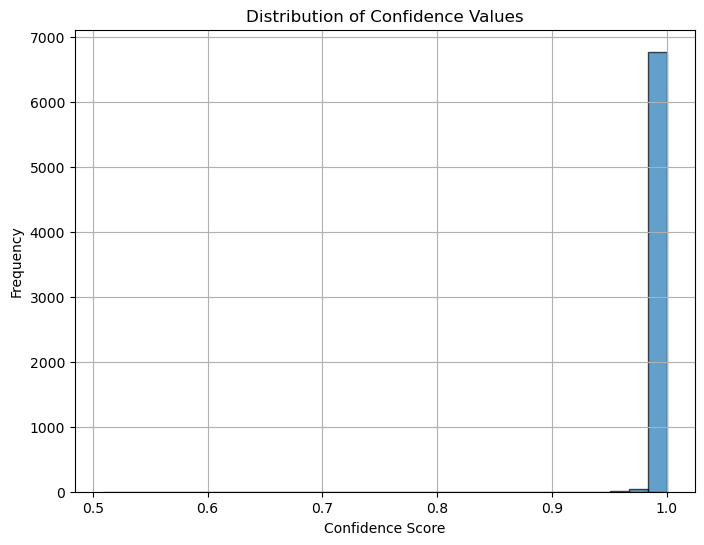

In [250]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the confidence values from the predictions
confidence_values = [p['confidence'] for p in filtered_predictions]

# Plot histogram of the confidence values
plt.figure(figsize=(8, 6))
plt.hist(confidence_values, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Confidence Values")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


##### Precision-Recall Curve

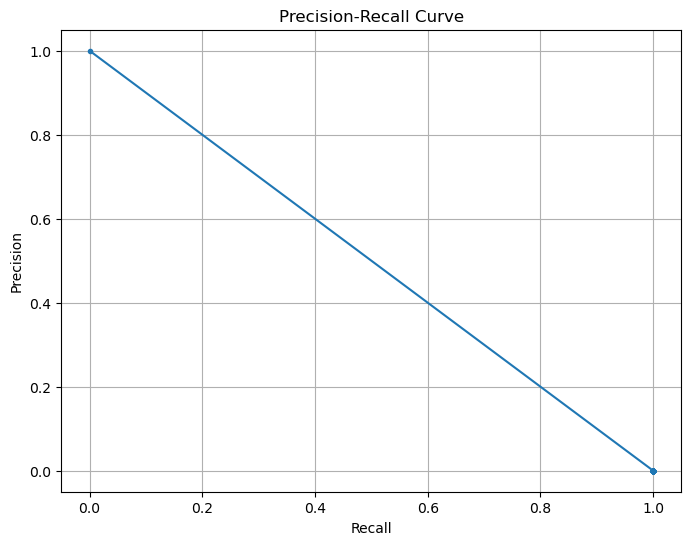

In [285]:
from sklearn.metrics import precision_recall_curve

# Extract ground truth labels and predicted confidence scores
y_true_map_filtered = []  # This will hold filtered ground truth labels
y_pred_confidence_filtered = []  # This will hold confidence values for predictions that survived NMS

# Loop through the filtered predictions and match them with the ground truth
for pred in filtered_predictions:
    # For each prediction surviving NMS, check if there's a corresponding ground truth
    # Here, we assume that you can align predictions with ground truth using some method, like nearest box or class matching
    # For simplicity, assume you have already matched predictions with corresponding ground truth boxes

    # Example: Get class ID for the prediction
    predicted_class = int(np.argmax(pred['confidence']))
    
    # Check ground truth (modify as per your dataset)
    for true in y_true_map:
        if true['class_id'] == predicted_class:  # Example match by class_id
            y_true_map_filtered.append(true['class_id'])
            y_pred_confidence_filtered.append(pred['confidence'])

# Ensure that both arrays have the same length after filtering
assert len(y_true_map_filtered) == len(y_pred_confidence_filtered), "Mismatch between ground truth and predictions after NMS"

# Compute precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_true_map_filtered, y_pred_confidence_filtered)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


In [287]:
import matplotlib.patches as patches

### Visualizing the bounding box predictions after applying NMS

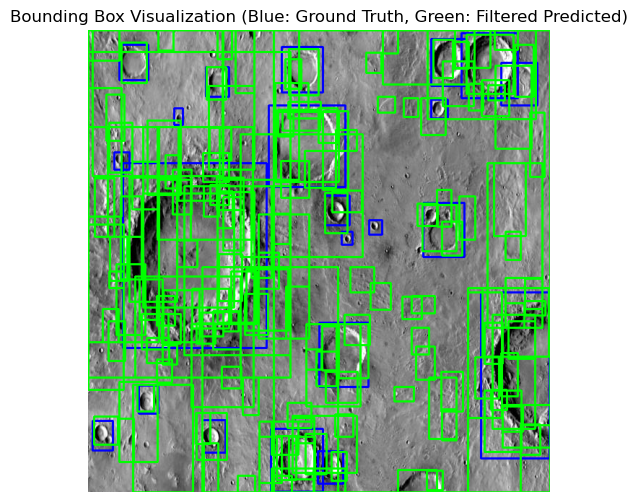

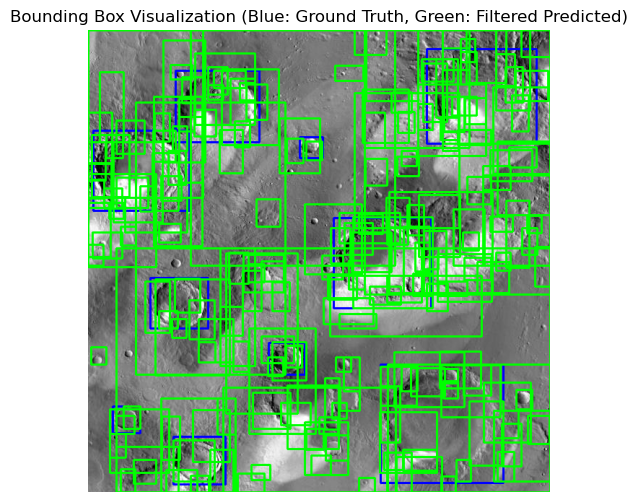

In [310]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize bounding boxes using cv2.rectangle
def visualize_bounding_boxes(image, ground_truths, filtered_bboxes):
    """
    Visualize ground truth and filtered bounding boxes on an image using cv2.rectangle.

    Parameters:
    - image: The original image (BGR format from cv2).
    - ground_truths: List of ground truth bounding boxes as dictionaries with keys 'x1', 'y1', 'x2', 'y2'.
    - filtered_bboxes: List of filtered bounding boxes after NMS with confidence scores.
    """
    image_copy = image.copy()  # Make a copy of the image to draw on

    # Draw ground truth boxes in blue
    for gt in ground_truths:
        cv2.rectangle(image_copy, (gt['x1'], gt['y1']), (gt['x2'], gt['y2']), (255, 0, 0), 2)  # Blue (BGR)
    
    # Draw filtered bounding boxes (after NMS) in green
    for bbox in filtered_bboxes:
        color = (0, 255, 0)  # Green (for the filtered predictions)
        cv2.rectangle(image_copy, (int(bbox['bbox'][0]), int(bbox['bbox'][1])), 
                       (int(bbox['bbox'][2]), int(bbox['bbox'][3])), color, 2)

    # Convert image to RGB for displaying using matplotlib
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title("Bounding Box Visualization (Blue: Ground Truth, Green: Filtered Predicted)")
    plt.axis("off")
    plt.show()

# Apply NMS and visualize
visualized_count = 0  # Counter to track the number of visualized images
max_visualizations = 2  # Number of images to visualize

# Process and visualize images
for e, i in enumerate(os.listdir(annot_val)):
    try:
        if visualized_count >= max_visualizations:
            break  # Stop after visualizing the specified number of images
        
        filename1 = i.split(".txt")[0] + ".jpg"
        image_path_val = os.path.join(path_val, filename1)
        annotation_path_val = os.path.join(annot_val, i)

        image_val = cv2.imread(image_path_val)
        if image_val is None:
            print(f"Image not found: {image_path_val}")
            continue

        height1, width1, _ = image_val.shape

        with open(annotation_path_val, 'r') as f:
            lines1 = f.readlines()

        # Parse the ground truth bounding boxes from the annotation file
        gtvalues1 = []
        for line1 in lines1:
            components1 = line1.strip().split()

            # Ensure the line contains valid components
            if len(components1) < 4:
                print(f"Invalid line in {i}: {line1}")
                continue

            try:
                center_x1, center_y1, bbox_width1, bbox_height1 = map(float, components1[1:])
                x1 = int((center_x1 - bbox_width1 / 2) * width1)
                x2 = int((center_x1 + bbox_width1 / 2) * width1)
                y1 = int((center_y1 - bbox_height1 / 2) * height1)
                y2 = int((center_y1 + bbox_height1 / 2) * height1)

                # Store the ground truth box as a dictionary
                gtvalues1.append({"x1": x1, "y1": y1, "x2": x2, "y2": y2})
            except ValueError as ve:
                print(f"Error parsing line in {i}: {line1}")
                continue

        # Perform selective search to propose bounding boxes
        ss.setBaseImage(image_val)
        ss.switchToSelectiveSearchFast()
        ssresults1 = ss.process()[:1000]

        added_bboxes_val = set()
        prediction_boxes_with_scores = []

        # Loop through the proposed bounding boxes and classify them
        for result1 in ssresults1:
            x_val, y_val, w_val, h_val = result1
            if w_val < 20 or h_val < 20:
                continue

            proposed_bbox_val = (x_val, y_val, x_val + w_val, y_val + h_val)

            # Store the bounding box and a dummy confidence score (or use IoU-based scoring)
            confidence_score = 0.9  # Placeholder confidence score
            prediction_boxes_with_scores.append({"bbox": proposed_bbox_val, "confidence": confidence_score})

        # Combine bounding boxes and scores into a tensor for NMS
        P = torch.tensor([
            np.concatenate([pred['bbox'], np.array([pred['confidence']])], axis=0)  # Concatenate bbox and confidence
            for pred in prediction_boxes_with_scores
        ], dtype=torch.float32)

        confidence_threshold = 0.3  
        P = P[P[:, 4] > confidence_threshold]  # Apply the confidence threshold

        # Apply NMS to the predictions (using IoU threshold of 0.5)
        thresh_iou = 0.3
        nms_output = nms_pytorch(P, thresh_iou)

        # Convert NMS output back into a list of predictions with filtered boxes and scores
        filtered_predictions = [{"bbox": pred[:4].tolist(), "confidence": pred[4].item()} for pred in nms_output]

        # Call visualization function with NMS filtered bounding boxes
        visualize_bounding_boxes(image_val, gtvalues1, filtered_predictions)

        visualized_count += 1  # Increment the counter after visualizing an image

    except Exception as e:
        print(f"Error processing file {i}: {e}")


In [319]:
# Save the model in HDF5 format
#model_1.save('my_best_model.h5')
model_1.save('my_best_model.keras')